<a href="https://colab.research.google.com/github/silvesco94/Where-did-the-aces-go-/blob/main/aces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict
from collections import defaultdict
import matplotlib.pyplot as plt

## Define an Ace

In [ ]:
# ---------------------- Config ----------------------
DATA_PATH = "/content/aces_data.csv"
WAR_MIN = 2.0
CAS_THRESHOLD = 1.5
WINSOR = (0.01, 0.99)

# ---------------------- Utilities -------------------
def _ranknorm(s):
    r = s.rank(method="average", pct=True).clip(1e-6, 1-1e-6)
    return r.apply(lambda p: float(np.sqrt(2) * math.erfinv(2*p - 1)))

def _zscore(s):
    s = pd.to_numeric(s, errors="coerce").astype(float)
    sd = s.std(ddof=0)
    return (s - s.mean())/sd if (np.isfinite(sd) and sd >= 1e-12) else _ranknorm(s)

def _winsor(s, lo=0.01, hi=0.99):
    ql, qh = s.quantile(lo), s.quantile(hi)
    return s.clip(ql, qh)

def _normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Map flexible column names to canonical ones and keep only needed fields."""
    lower = {c.lower(): c for c in df.columns}

    def need(opts, label):
        for k in opts:
            if k in lower:
                return lower[k]  # return ORIGINAL-cased column name
        raise ValueError(f"Missing required column for {label}: tried {opts}")

    season_col = need(("season",), "Season")
    name_col   = need(("name","player","playername"), "Name")
    era_col    = need(("era",), "ERA")
    whip_col   = need(("whip",), "WHIP")
    k9_col     = need(("k/9","so/9","k9","so9","k_per_9","kper9","strikeouts/9"), "K/9")
    war_col    = need(("war",), "WAR")

    out = df.rename(columns={
        season_col: "Season",
        name_col:   "Name",
        era_col:    "ERA",
        whip_col:   "WHIP",
        k9_col:     "K9",     # <-- use the ORIGINAL column name directly
        war_col:    "WAR",
    })[["Season","Name","ERA","WHIP","K9","WAR"]].copy()

    out["Season"] = pd.to_numeric(out["Season"], errors="coerce").astype("Int64")
    for c in ("ERA","WHIP","K9","WAR"):
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out.dropna(subset=["Season","ERA","WHIP","K9","WAR"])
# ------------------ Compute Ace flags ----------------
def compute_ace_flags(df_raw, war_min=WAR_MIN, cas_threshold=CAS_THRESHOLD, winsor=WINSOR):
    df = _normalize_cols(df_raw)
    df["Eligible"] = df["WAR"] >= war_min
    elig = df[df["Eligible"]].copy()
    if elig.empty:
        raise ValueError("No eligible rows after WAR threshold.")

    lo, hi = winsor
    def per_year(g):
        g = g.copy()
        for c in ("ERA","WHIP","K9","WAR"):
            g[c+"_w"] = _winsor(g[c], lo, hi)
            g["z_"+c] = _zscore(g[c+"_w"])
        g["z_ERA_INV"]  = -g["z_ERA"]
        g["z_WHIP_INV"] = -g["z_WHIP"]
        g["CAS"] = 0.25*g["z_ERA_INV"] + 0.25*g["z_WHIP_INV"] + 0.25*g["z_K9"] + 0.25*g["z_WAR"]
        g["AceSeason"] = g["CAS"] >= cas_threshold
        return g

    seasons = elig.groupby("Season", group_keys=False).apply(per_year).reset_index(drop=True)
    return seasons[["Season","Name","ERA","WHIP","K9","WAR","CAS","AceSeason","Eligible"]]

# ------------------ Validation tests ----------------
def repeatability(seasons, window_years=2):
    """% who repeat an AceSeason within next N years vs baseline for non-aces."""
    next_map = defaultdict(list)
    for name, g in seasons.groupby("Name"):
        ys = sorted(g["Season"].astype(int).tolist())
        ace_years = set(g.loc[g["AceSeason"], "Season"].astype(int).tolist())
        for y in ys:
            window = set(range(y+1, y+window_years+1))
            has_future_ace = len(ace_years.intersection(window)) > 0
            next_map["is_ace_now"].append(y in ace_years)
            next_map["has_future_ace"].append(has_future_ace)
    df = pd.DataFrame(next_map)
    ace_now = df[df["is_ace_now"]]
    non_now = df[~df["is_ace_now"]]
    return {
        "ace_repeat_rate": ace_now["has_future_ace"].mean() if len(ace_now) else np.nan,
        "nonace_to_ace_rate": non_now["has_future_ace"].mean() if len(non_now) else np.nan,
        "lift": (ace_now["has_future_ace"].mean() / non_now["has_future_ace"].mean()) if len(ace_now) and non_now["has_future_ace"].mean() > 0 else np.nan
    }

def next_year_auc_and_lift(seasons: pd.DataFrame, top_q=0.90):
    """
    Predict next-year success using current-year CAS.
    Success = next-year WAR percentile >= top_q among that next-year's eligible SP.
    Returns AUC (via Mann–Whitney) and lift for top CAS decile.
    """
    # current rows + Season_next
    cur = seasons.copy()
    cur["Season_next"] = cur["Season"] + 1

    # next-year WAR for the same pitcher
    nxt = seasons[["Name", "Season", "WAR"]].rename(
        columns={"Season": "Season_next", "WAR": "WAR_next"}
    )

    # next-year WAR percentile (among all pitchers in that next year)
    pcts = seasons[["Name", "Season", "WAR"]].copy()
    pcts["WAR_next_pct"] = pcts.groupby("Season")["WAR"].rank(pct=True)
    pcts = pcts.rename(columns={"Season": "Season_next"})

    # merge
    merged = (
        cur.merge(nxt, on=["Name", "Season_next"], how="left")
           .merge(pcts[["Name", "Season_next", "WAR_next_pct"]],
                  on=["Name", "Season_next"], how="left")
    )

    # keep rows that actually have a next year
    test = merged.dropna(subset=["WAR_next", "WAR_next_pct"]).copy()
    if test.empty or test["WAR_next_pct"].isna().all():
        return {"auc_approx": np.nan, "top_decile_lift": np.nan, "baseline_positive_rate": np.nan}

    # binary target: top decile (or chosen quantile) next year
    test["y"] = (test["WAR_next_pct"] >= top_q).astype(int)

    # AUC via Mann–Whitney U (equivalent to ROC-AUC with ranking)
    ranks = test["CAS"].rank(method="average")
    pos = ranks[test["y"] == 1]
    neg = ranks[test["y"] == 0]
    if len(pos) == 0 or len(neg) == 0:
        auc = np.nan
    else:
        U = pos.sum() - len(pos) * (len(pos) + 1) / 2.0
        auc = U / (len(pos) * len(neg))

    # top-decile lift of CAS
    cutoff = test["CAS"].quantile(0.90)
    top_decile = test[test["CAS"] >= cutoff]
    base = test["y"].mean()
    lift = (top_decile["y"].mean() / base) if base and not np.isnan(base) else np.nan

    return {"auc_approx": float(auc), "top_decile_lift": float(lift), "baseline_positive_rate": float(base)}


def convergent_without_war(seasons):
    """Correlation between WAR-less composite and same-year WAR percentile."""
    g = seasons.copy()
    # WAR-less composite (equal weights among ERA_INV, WHIP_INV, K9)
    g["CAS_noWAR"] = (1/3)*(-_zscore(g["ERA"])) + (1/3)*(-_zscore(g["WHIP"])) + (1/3)*(_zscore(g["K9"]))
    g["WAR_pct_sameyear"] = g.groupby("Season")["WAR"].rank(pct=True)
    spear = g["CAS_noWAR"].corr(g["WAR_pct_sameyear"], method="spearman")
    return {"spearman_CASnoWAR_vs_WARpct": float(spear)}

def sensitivity(seasons, thresholds=(1.25,1.5,1.75)):
    out = []
    for th in thresholds:
        s = seasons.copy()
        s["AceSeason_tmp"] = s["CAS"] >= th
        # Repeatability with temp flag
        tmp = []
        for name, g in s.groupby("Name"):
            ys = sorted(g.loc[g["AceSeason_tmp"], "Season"].dropna().astype(int).unique())
            is_ace_repeat = 0
            for i, y0 in enumerate(ys):
                if any((y0+1==y) or (y0+2==y) for y in ys):
                    is_ace_repeat = 1; break
            tmp.append(is_ace_repeat)
        rep_rate = np.mean(tmp) if len(tmp) else np.nan
        out.append({"CAS_threshold": th, "prevalence": float((s["AceSeason_tmp"].mean())), "repeat_rate_any_next2y": float(rep_rate)})
    return pd.DataFrame(out)

# ------------------------- Run ---------------------------------
df_in = pd.read_csv(DATA_PATH)
seasons = compute_ace_flags(df_in, war_min=WAR_MIN, cas_threshold=CAS_THRESHOLD, winsor=WINSOR)

print("Rows eligible:", len(seasons), " | Ace-season prevalence:", seasons["AceSeason"].mean())

rep = repeatability(seasons, window_years=2)
print("\nRepeatability (next 1–2 yrs):")
for k,v in rep.items(): print(f"  {k}: {v:.3f}" if pd.notna(v) else f"  {k}: NA")

pred = next_year_auc_and_lift(seasons, top_q=0.90)
print("\nPredictive power to next-year top-10% WAR:")
for k,v in pred.items(): print(f"  {k}: {v:.3f}" if pd.notna(v) else f"  {k}: NA")

conv = convergent_without_war(seasons)
print("\nConvergent validity (CAS without WAR vs same-year WAR percentile):")
for k,v in conv.items(): print(f"  {k}: {v:.3f}" if pd.notna(v) else f"  {k}: NA")

sens = sensitivity(seasons, thresholds=(1.25,1.50,1.75))
print("\nSensitivity (threshold sweep):")
print(sens.to_string(index=False))

/tmp/ipython-input-6753742.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasons = elig.groupby("Season", group_keys=False).apply(per_year).reset_index(drop=True)


Rows eligible: 7030  | Ace-season prevalence: 0.041678520625889046

Repeatability (next 1–2 yrs):
  ace_repeat_rate: 0.437
  nonace_to_ace_rate: 0.036
  lift: 12.212

Predictive power to next-year top-10% WAR:
  auc_approx: 0.731
  top_decile_lift: 3.048
  baseline_positive_rate: 0.158

Convergent validity (CAS without WAR vs same-year WAR percentile):
  spearman_CASnoWAR_vs_WARpct: 0.448

Sensitivity (threshold sweep):
 CAS_threshold  prevalence  repeat_rate_any_next2y
          1.25    0.064723                0.039563
          1.50    0.041679                0.025508
          1.75    0.023044                0.014576


## TL;DR
- I define an **Ace Season** as a year where a starter dominates peers across **ERA, WHIP, K/9, WAR**, standardized **within that year**.
- With **WAR ≥ 2.0** (workload floor) and **Composite Ace Score (CAS) ≥ 1.5**, about **4.2%** of seasons qualify.
- **CAS** (Composite Ace Score) = the average of within-year z-scores of **−ERA, −WHIP, K/9, WAR** (so higher = better).
- These seasons are ~**12×** more likely to be followed by another Ace Season and **predict next-year success** (AUC ≈ **0.73**).

## What I measured
- **Who counts:** Seasons with **WAR ≥ 2.0**.
- **CAS (Composite Ace Score):** A single number summarizing dominance that compares each pitcher **only to pitchers from the same year**. It averages standardized values of **ERA (inverted), WHIP (inverted), K/9, WAR**. A **CAS of +1.5** means the pitcher is roughly **1.5 standard deviations better** than peers on that combined scale.
- **How I score:** Per year, z-score **ERA, WHIP, K/9, WAR**; flip ERA/WHIP (lower→better); average → **CAS**.
- **Ace Season:** **CAS ≥ 1.5**.
- *(Era analysis comes later; this article validates the definition.)*

## Why it’s fair
- **Year-relative** (accounts for run environment & K rates).
- **Four lenses:** run prevention (ERA/WHIP), strikeout dominance (K/9), overall value (WAR).
- **Workload floor** avoids tiny, fluky seasons.

## Results (highlights)
- **Eligible seasons:** 7,030
- **Ace-season prevalence:** **4.17%** (~1 in 24).
- **Repeatability (next 1–2 yrs):**
  - Aces repeat: **43.7%**
  - Non-aces become aces: **3.6%**
  - **Lift:** ~**12×**
- **Predictive power (next year top-10% WAR):**
  - **AUC ≈ 0.731**
  - **Top-decile lift ≈ 3.05×**
  - Baseline top-10% rate: **15.8%**
- **Non-WAR agreement:** (ERA/WHIP/K9-only) vs same-year WAR percentile → **Spearman 0.448** (moderate).

## Methods (one paragraph)
- **Eligibility:** WAR ≥ 2.0.  
- **Standardize per year:** z-score ERA, WHIP, K/9, WAR; invert ERA/WHIP so higher is better.  
- **Composite (CAS):** `CAS = 0.25·z(-ERA) + 0.25·z(-WHIP) + 0.25·z(K/9) + 0.25·z(WAR)`  
- **Ace Season threshold:** CAS ≥ 1.5.  
- **Robustness:** Winsorize extremes (1st/99th pct); rank-normalize if variance is tiny.

## Threshold sensitivity
- **CAS 1.25 → 6.47%** aces (looser)
- **CAS 1.50 → 4.17%** (baseline)
- **CAS 1.75 → 2.30%** (stricter)
- Stricter bar → fewer aces; repeatability remains solid.

## Figures to include
- **Fig 1:** Yearly ace-season prevalence (line).  
  *Caption:* “~4% of starter seasons clear the ace bar; year-relative metric adapts to the run environment.”
- **Fig 2:** Threshold sensitivity (bar/table for 1.25/1.50/1.75).  
  *Caption:* “Tighter threshold lowers prevalence but retains stability.”

## Anticipated questions
- **Why include WAR if it’s volume-based?** We enforce a WAR floor, then balance with rate stats; non-WAR components still align with value (ρ ≈ **0.45**).
- **Why not wins/Cy votes?** Team/era bias; this is **skill + workload**, standardized by year.
- **Is 1.5 too high?** Intentional strictness; sensitivity shows similar stories at 1.25–1.75.


Mean stats for Ace Seasons:
ERA     2.322
WHIP    1.031
K9      7.748
WAR     7.104
dtype: float64


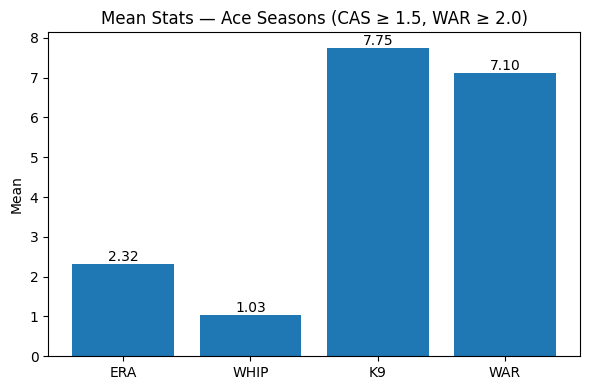

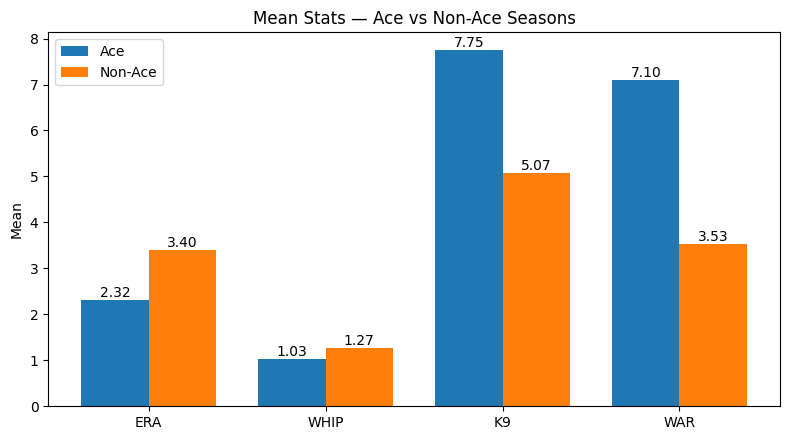

In [ ]:
stats = ["ERA", "WHIP", "K9", "WAR"]

# Filter and compute means
aces = seasons[seasons["AceSeason"]].copy()
non_aces = seasons[~seasons["AceSeason"]].copy()

ace_means = aces[stats].mean()
non_means = non_aces[stats].mean()

print("Mean stats for Ace Seasons:")
print(ace_means.round(3))

# 1) Single bar chart: Ace means
plt.figure(figsize=(6, 4))
bars = plt.bar(stats, ace_means.values)
plt.title("Mean Stats — Ace Seasons (CAS ≥ 1.5, WAR ≥ 2.0)")
plt.ylabel("Mean")
for i, v in enumerate(ace_means.values):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# 2) Grouped bar chart: Ace vs Non-Ace means
x = np.arange(len(stats))
width = 0.38

plt.figure(figsize=(8, 4.5))
plt.bar(x - width/2, ace_means.values, width, label="Ace")
plt.bar(x + width/2, non_means.values, width, label="Non-Ace")
plt.title("Mean Stats — Ace vs Non-Ace Seasons")
plt.ylabel("Mean")
plt.xticks(x, stats)
plt.legend()
# annotate bars
for i, (va, vn) in enumerate(zip(ace_means.values, non_means.values)):
    plt.text(i - width/2, va, f"{va:.2f}", ha="center", va="bottom")
    plt.text(i + width/2, vn, f"{vn:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


Yearly-by-era prevalence (head):
   Season             Era  eligible_sp_seasons  ace_seasons  prevalence
0    1871  Pre-Mound Move                    6            0         0.0
1    1872  Pre-Mound Move                    6            0         0.0
2    1873  Pre-Mound Move                    7            0         0.0
3    1874  Pre-Mound Move                    7            0         0.0
4    1875  Pre-Mound Move                   11            0         0.0

Era summary (normalized by era length):
                        Era  years_in_era  mean_yearly_prevalence  aces_per_100_sp_seasons  unique_aces_2in3  unique_aces_per_year
                Juiced Ball             4                0.063807                 6.349206               3.0              0.750000
                    Steroid            11                0.059688                 5.993691               6.0              0.545455
          Velocity/Statcast             6                0.051965                 5.128205          

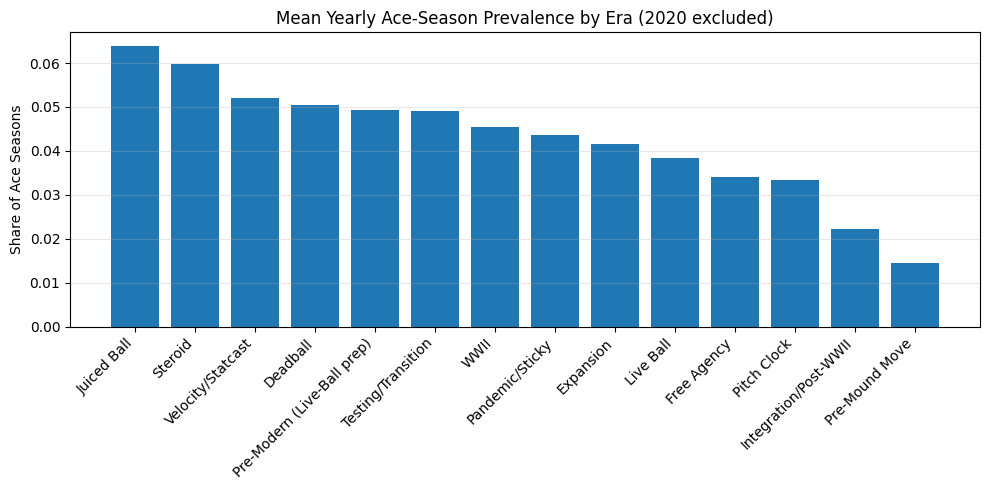

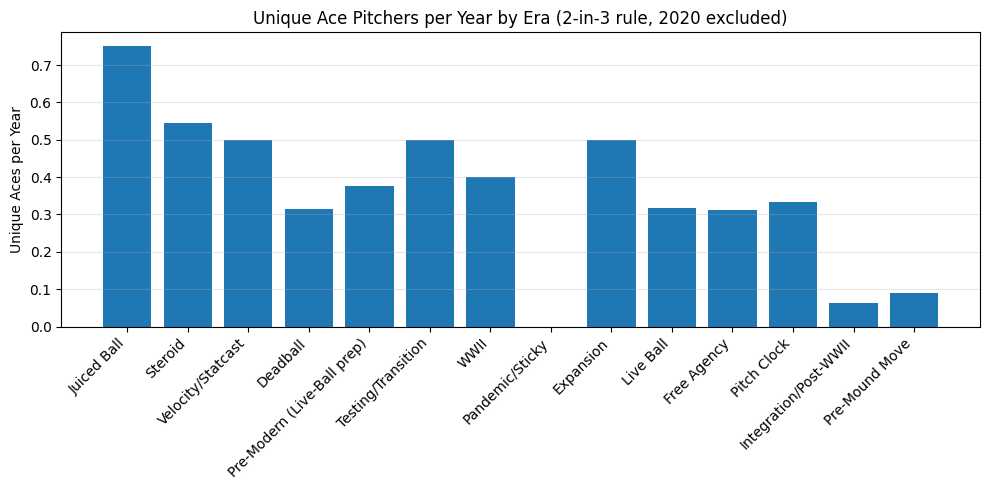

In [ ]:
# -------------------- Era mapping (+ drop 2020) --------------------
ERA_BUCKETS = [
    ("Pre-Mound Move",             1871, 1892),
    ("Pre-Modern (Live-Ball prep)",1893, 1900),
    ("Deadball",                   1901, 1919),
    ("Live Ball",                  1920, 1941),
    ("WWII",                       1942, 1946),
    ("Integration/Post-WWII",      1947, 1962),
    ("Expansion",                  1963, 1976),
    ("Free Agency",                1977, 1992),
    ("Steroid",                    1993, 2003),
    ("Testing/Transition",         2004, 2009),
    ("Velocity/Statcast",          2010, 2015),
    ("Juiced Ball",                2016, 2019),
    # 2020 intentionally excluded
    ("Pandemic/Sticky",            2021, 2022),
    ("Pitch Clock",                2023, 3000),
]

def map_era(year: int) -> str:
    for label, start, end in ERA_BUCKETS:
        if start <= year <= end:
            return label
    return "Unknown"

# Ensure `seasons` exists (compute if this is a fresh cell)
try:
    seasons
except NameError:
    df_in = pd.read_csv(DATA_PATH)
    seasons = compute_ace_flags(df_in, war_min=WAR_MIN, cas_threshold=CAS_THRESHOLD, winsor=WINSOR)

# Apply mapping and drop 2020
seasons_era = seasons[seasons["Season"] != 2020].copy()
seasons_era["Era"] = seasons_era["Season"].astype(int).apply(map_era)

# -------------------- Yearly-by-era prevalence --------------------
yearly_by_era = (
    seasons_era
    .groupby(["Season", "Era"])
    .agg(
        eligible_sp_seasons=("Name", "count"),
        ace_seasons=("AceSeason", "sum"),
    )
    .reset_index()
)
yearly_by_era["prevalence"] = yearly_by_era["ace_seasons"] / yearly_by_era["eligible_sp_seasons"]

# -------------------- Unique ace pitchers per era (2-in-3 rule) --------------------
def ace_pitchers_within_era(df):
    rows = []
    for (name, era), g in df.groupby(["Name", "Era"]):
        ys = sorted(g.loc[g["AceSeason"], "Season"].dropna().astype(int).unique())
        is_ace = False
        for y0 in ys:
            if sum((y0 <= y <= y0 + 2) for y in ys) >= 2:
                is_ace = True
                break
        if is_ace:
            rows.append({"Name": name, "Era": era})
    return pd.DataFrame(rows)

ace_pitchers_df = ace_pitchers_within_era(seasons_era)
ace_counts = (
    ace_pitchers_df.groupby("Era")["Name"].nunique()
    .rename("unique_aces_2in3")
    .reset_index()
)

# -------------------- Era summary (length-normalized) --------------------
era_summary = (
    yearly_by_era.groupby("Era")
    .agg(
        years_in_era=("Season", "nunique"),
        mean_yearly_prevalence=("prevalence", "mean"),   # primary (fixes uneven era length)
        total_eligible=("eligible_sp_seasons", "sum"),
        total_ace_seasons=("ace_seasons", "sum"),
    )
    .reset_index()
)
era_summary["aces_per_100_sp_seasons"] = (
    era_summary["total_ace_seasons"] / era_summary["total_eligible"] * 100.0
)
era_summary = era_summary.merge(ace_counts, on="Era", how="left").fillna({"unique_aces_2in3": 0})
era_summary["unique_aces_per_year"] = era_summary["unique_aces_2in3"] / era_summary["years_in_era"]
era_summary = era_summary.sort_values("mean_yearly_prevalence", ascending=False)

print("\nYearly-by-era prevalence (head):")
print(yearly_by_era.head())

print("\nEra summary (normalized by era length):")
print(era_summary[[
    "Era","years_in_era","mean_yearly_prevalence","aces_per_100_sp_seasons","unique_aces_2in3","unique_aces_per_year"
]].to_string(index=False))

# -------------------- Charts (matplotlib, one plot per figure, no explicit colors) --------------------
# 1) Mean yearly prevalence by era (primary metric)
plt.figure(figsize=(10, 5))
plt.bar(era_summary["Era"], era_summary["mean_yearly_prevalence"])
plt.title("Mean Yearly Ace-Season Prevalence by Era (2020 excluded)")
plt.ylabel("Share of Ace Seasons")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Unique aces per year by era (2-in-3 rule)
plt.figure(figsize=(10, 5))
plt.bar(era_summary["Era"], era_summary["unique_aces_per_year"])
plt.title("Unique Ace Pitchers per Year by Era (2-in-3 rule, 2020 excluded)")
plt.ylabel("Unique Aces per Year")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# --- Who are the aces in the Pitch Clock era? ---

# Ensure `seasons_era` and `ace_pitchers_df` exist
try:
    seasons_era
except NameError:
    df_in = pd.read_csv(DATA_PATH)
    seasons = compute_ace_flags(df_in, war_min=WAR_MIN, cas_threshold=CAS_THRESHOLD, winsor=WINSOR)
    seasons_era = seasons[seasons["Season"] != 2020].copy()

ERA_BUCKETS = [
    ("Pre-Mound Move",             1871, 1892),
    ("Pre-Modern (Live-Ball prep)",1893, 1900),
    ("Deadball",                   1901, 1919),
    ("Live Ball",                  1920, 1941),
    ("WWII",                       1942, 1946),
    ("Integration/Post-WWII",      1947, 1962),
    ("Expansion",                  1963, 1976),
    ("Free Agency",                1977, 1992),
    ("Steroid",                    1993, 2003),
    ("Testing/Transition",         2004, 2009),
    ("Velocity/Statcast",          2010, 2015),
    ("Juiced Ball",                2016, 2019),
    ("Pandemic/Sticky",            2021, 2022),
    ("Pitch Clock",                2023, 3000),
]
def map_era(year: int) -> str:
    for label, start, end in ERA_BUCKETS:
        if start <= int(year) <= end:
            return label
    return "Unknown"

if "Era" not in seasons_era.columns:
    seasons_era["Era"] = seasons_era["Season"].astype(int).apply(map_era)

# 2-in-3 rule within era (build if not already built)
def ace_pitchers_within_era(df):
    rows = []
    for (name, era), g in df.groupby(["Name", "Era"]):
        yrs = sorted(g.loc[g["AceSeason"], "Season"].dropna().astype(int).unique())
        is_ace = any(sum(y0 <= y <= y0+2 for y in yrs) >= 2 for y0 in yrs)
        if is_ace:
            rows.append({"Name": name, "Era": era})
    return pd.DataFrame(rows)

try:
    ace_pitchers_df
except NameError:
    ace_pitchers_df = ace_pitchers_within_era(seasons_era)

# List names
pitch_clock_names = (
    ace_pitchers_df.loc[ace_pitchers_df["Era"] == "Pitch Clock", "Name"]
    .dropna().sort_values().unique()
)
print(f"{len(pitch_clock_names)} unique aces in the Pitch Clock era:")
for n in pitch_clock_names:
    print(" -", n)

# Show their Ace Seasons (CAS ≥ threshold) in Pitch Clock era
ace_seasons_pc = (
    seasons_era[(seasons_era["Era"] == "Pitch Clock") & (seasons_era["AceSeason"])]
    .loc[:, ["Season","Name","CAS","ERA","WHIP","K9","WAR"]]
    .sort_values(["Name","Season"])
)
print("\nAce Seasons in Pitch Clock era:")
print(ace_seasons_pc.to_string(index=False))


1 unique aces in the Pitch Clock era:
 - Tarik Skubal

Ace Seasons in Pitch Clock era:
 Season         Name      CAS      ERA     WHIP        K9      WAR
   2024   Chris Sale 2.004120 2.380863 1.013133 11.397749 6.401676
   2024 Tarik Skubal 2.007146 2.390625 0.921875 10.687500 5.926991
   2025 Tarik Skubal 1.740464 2.422320 0.873085 11.225383 5.483705
   2024 Zack Wheeler 1.585895 2.565000 0.955000 10.080000 5.414309



[2125] Yearly-by-era prevalence (head):
   Season        Era_2125  eligible_sp_seasons  ace_seasons  prevalence
0    1871  Pre-Mound Move                    6            0         0.0
1    1872  Pre-Mound Move                    6            0         0.0
2    1873  Pre-Mound Move                    7            0         0.0
3    1874  Pre-Mound Move                    7            0         0.0
4    1875  Pre-Mound Move                   11            0         0.0

[2125] Era summary (normalized by era length):
                   Era_2125  years_in_era  mean_yearly_prevalence  aces_per_100_sp_seasons  unique_aces_2in3  unique_aces_per_year
                Juiced Ball             4                0.063807                 6.349206                 3              0.750000
                    Steroid            11                0.059688                 5.993691                 6              0.545455
          Velocity/Statcast             6                0.051965                 5.12

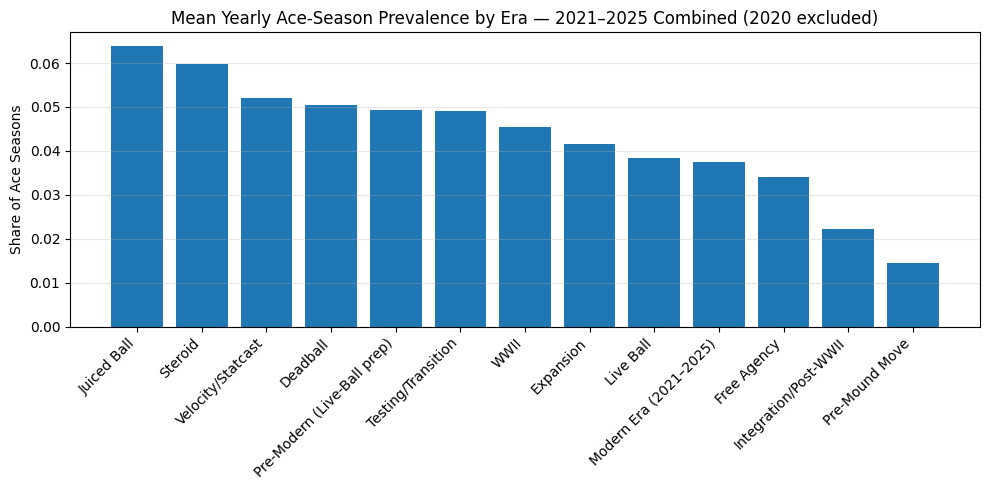

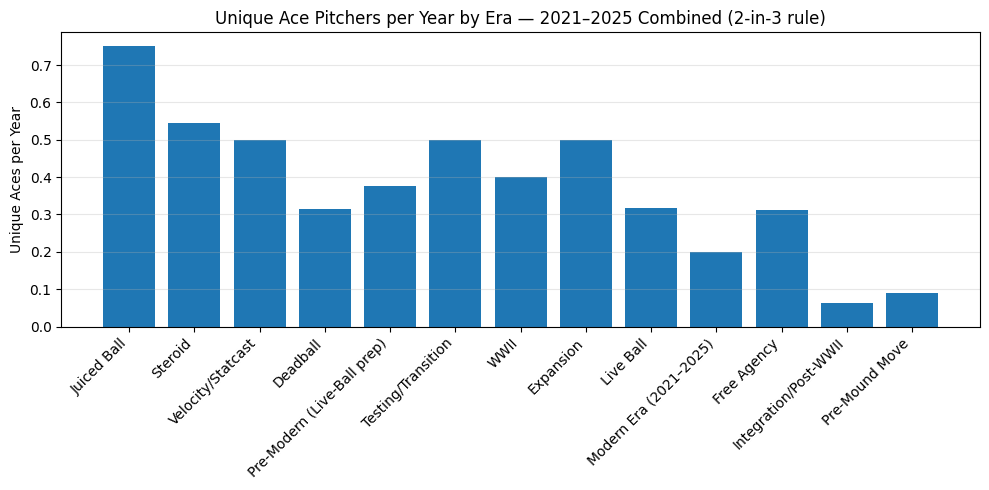

In [ ]:
ERA_BUCKETS_2125 = [
    ("Pre-Mound Move",              1871, 1892),
    ("Pre-Modern (Live-Ball prep)", 1893, 1900),
    ("Deadball",                    1901, 1919),
    ("Live Ball",                   1920, 1941),
    ("WWII",                        1942, 1946),
    ("Integration/Post-WWII",       1947, 1962),
    ("Expansion",                   1963, 1976),
    ("Free Agency",                 1977, 1992),
    ("Steroid",                     1993, 2003),
    ("Testing/Transition",          2004, 2009),
    ("Velocity/Statcast",           2010, 2015),
    ("Juiced Ball",                 2016, 2019),
    # 2020 intentionally excluded
    ("Modern Era (2021–2025)",    2021, 2025),
]

def map_era_2125(year: int) -> str:
    for label, start, end in ERA_BUCKETS_2125:
        if start <= int(year) <= end:
            return label
    return "Unknown"

# Ensure `seasons` exists (compute if this is a fresh cell)
try:
    seasons
except NameError:
    df_in = pd.read_csv(DATA_PATH)
    seasons = compute_ace_flags(df_in, war_min=WAR_MIN, cas_threshold=CAS_THRESHOLD, winsor=WINSOR)

# Apply mapping (drop 2020) for the 2021–2025-combined view
seasons_era_2125 = seasons[seasons["Season"] != 2020].copy()
seasons_era_2125["Era_2125"] = seasons_era_2125["Season"].astype(int).apply(map_era_2125)

# -------------------- Yearly-by-era prevalence (2125) --------------------
yearly_by_era_2125 = (
    seasons_era_2125
    .groupby(["Season", "Era_2125"])
    .agg(
        eligible_sp_seasons=("Name", "count"),
        ace_seasons=("AceSeason", "sum"),
    )
    .reset_index()
)
yearly_by_era_2125["prevalence"] = (
    yearly_by_era_2125["ace_seasons"] / yearly_by_era_2125["eligible_sp_seasons"]
)

# -------------------- Unique ace pitchers per era (2-in-3, 2125) --------------------
def ace_pitchers_within_era_generic(df, era_col):
    rows = []
    for (name, era), g in df.groupby(["Name", era_col]):
        yrs = sorted(g.loc[g["AceSeason"], "Season"].dropna().astype(int).unique())
        is_ace = any(sum(y0 <= y <= y0 + 2 for y in yrs) >= 2 for y0 in yrs)
        if is_ace:
            rows.append({"Name": name, era_col: era})
    return pd.DataFrame(rows)

ace_pitchers_df_2125 = ace_pitchers_within_era_generic(seasons_era_2125, "Era_2125")
ace_counts_2125 = (
    ace_pitchers_df_2125.groupby("Era_2125")["Name"].nunique()
    .rename("unique_aces_2in3")
    .reset_index()
)

# -------------------- Era summary (length-normalized, 2125) --------------------
era_summary_2125 = (
    yearly_by_era_2125.groupby("Era_2125")
    .agg(
        years_in_era=("Season", "nunique"),
        mean_yearly_prevalence=("prevalence", "mean"),   # primary metric
        total_eligible=("eligible_sp_seasons", "sum"),
        total_ace_seasons=("ace_seasons", "sum"),
    )
    .reset_index()
)
era_summary_2125["aces_per_100_sp_seasons"] = (
    era_summary_2125["total_ace_seasons"] / era_summary_2125["total_eligible"] * 100.0
)
era_summary_2125 = (
    era_summary_2125
    .merge(ace_counts_2125, on="Era_2125", how="left")
    .fillna({"unique_aces_2in3": 0})
)
era_summary_2125["unique_aces_per_year"] = (
    era_summary_2125["unique_aces_2in3"] / era_summary_2125["years_in_era"]
)
era_summary_2125 = era_summary_2125.sort_values("mean_yearly_prevalence", ascending=False)

print("\n[2125] Yearly-by-era prevalence (head):")
print(yearly_by_era_2125.head())

print("\n[2125] Era summary (normalized by era length):")
print(era_summary_2125[[
    "Era_2125","years_in_era","mean_yearly_prevalence",
    "aces_per_100_sp_seasons","unique_aces_2in3","unique_aces_per_year"
]].to_string(index=False))

# -------------------- Charts --------------------
# 1) Mean yearly prevalence by era (2125 mapping)
plt.figure(figsize=(10, 5))
plt.bar(era_summary_2125["Era_2125"], era_summary_2125["mean_yearly_prevalence"])
plt.title("Mean Yearly Ace-Season Prevalence by Era — 2021–2025 Combined (2020 excluded)")
plt.ylabel("Share of Ace Seasons")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Unique aces per year by era (2-in-3 rule; 2125 mapping)
plt.figure(figsize=(10, 5))
plt.bar(era_summary_2125["Era_2125"], era_summary_2125["unique_aces_per_year"])
plt.title("Unique Ace Pitchers per Year by Era — 2021–2025 Combined (2-in-3 rule)")
plt.ylabel("Unique Aces per Year")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 95% confidence


[2125] Era prevalence with 95% CIs (bootstrap over years):
                   Era_2125     mean       lo       hi  n_years
                Juiced Ball 0.063807 0.047442 0.077182        4
                    Steroid 0.059688 0.050965 0.069585       11
          Velocity/Statcast 0.051965 0.040138 0.064053        6
                   Deadball 0.050420 0.042326 0.058312       19
Pre-Modern (Live-Ball prep) 0.049424 0.040775 0.058250        8
         Testing/Transition 0.049065 0.030389 0.070391        6
                       WWII 0.045510 0.032984 0.058546        5
                  Expansion 0.041556 0.032133 0.051243       14
                  Live Ball 0.038368 0.032434 0.044358       22
     Modern Era (2021–2025) 0.037493 0.017479 0.059339        5
                Free Agency 0.034137 0.028255 0.040182       16
      Integration/Post-WWII 0.022299 0.013360 0.031965       16
             Pre-Mound Move 0.014413 0.006295 0.023185       22


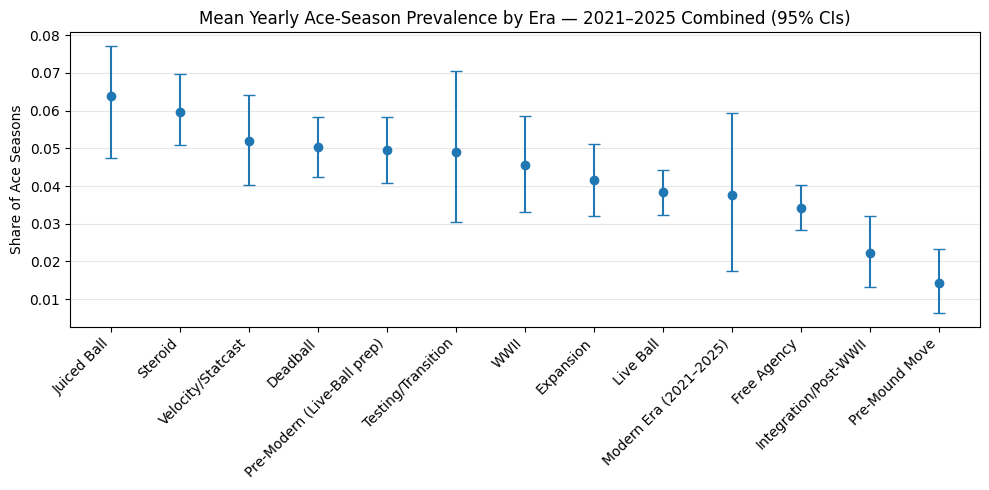

In [ ]:
# -------- 95% CIs for mean yearly prevalence (works with Era_2125) --------
def era_prevalence_ci_generic(yearly_df, era_col="Era", n_boot=5000, seed=42):
    rng = np.random.default_rng(seed)
    rows = []
    for era, g in yearly_df.groupby(era_col):
        vals = g["prevalence"].dropna().values
        n = len(vals)
        if n == 0:
            rows.append({era_col: era, "mean": np.nan, "lo": np.nan, "hi": np.nan, "n_years": 0})
            continue
        boots = [rng.choice(vals, size=n, replace=True).mean() for _ in range(n_boot)]
        lo, hi = np.percentile(boots, [2.5, 97.5])
        rows.append({era_col: era, "mean": vals.mean(), "lo": lo, "hi": hi, "n_years": n})
    return pd.DataFrame(rows).sort_values("mean", ascending=False)

# Apply to your 2021–2025 combined eras
era_ci_2125 = era_prevalence_ci_generic(yearly_by_era_2125, era_col="Era_2125")

print("\n[2125] Era prevalence with 95% CIs (bootstrap over years):")
print(era_ci_2125.to_string(index=False))

# Error-bar chart (single plot, matplotlib, no explicit colors)
plt.figure(figsize=(10,5))
x = np.arange(len(era_ci_2125))
plt.errorbar(
    x, era_ci_2125["mean"],
    yerr=[era_ci_2125["mean"] - era_ci_2125["lo"], era_ci_2125["hi"] - era_ci_2125["mean"]],
    fmt='o', capsize=4
)
plt.xticks(x, era_ci_2125["Era_2125"], rotation=45, ha="right")
plt.title("Mean Yearly Ace-Season Prevalence by Era — 2021–2025 Combined (95% CIs)")
plt.ylabel("Share of Ace Seasons")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Each dot is an era’s average share of ace seasons per year—i.e., in a typical year of that era, what % of eligible starters hit your ace bar (CAS ≥ 1.5, WAR ≥ 2.0). Higher dots mean ace years were more common. In your plot, Juiced Ball and Steroid eras are highest (roughly 6–6.5% of starters per year), middle eras sit around 4–5%, and Integration/Post-WWII and Pre-Mound Move are lowest.

The vertical lines are 95% confidence intervals (95% CI)—they show the uncertainty around each era’s average. A simple way to think about it: if you could re-sample seasons from that era many times, about 95% of the intervals built this way would capture the true era average. Wider bars = less certainty (usually because the era has fewer years, like the Modern Era (2021–2025)), so treat those estimates as noisier; narrower bars = more stable estimates.

## Confirmed + "In-progress"


[2125] Confirmed vs In-progress aces per era:
                   Era_2125  confirmed_aces_2in3  in_progress_aces_ge1  total_with_any_ace
                  Expansion                    7                    11                  18
                  Live Ball                    7                    17                  24
                   Deadball                    6                    11                  17
                    Steroid                    6                     7                  13
                Free Agency                    5                    14                  19
          Velocity/Statcast                    3                     8                  11
                Juiced Ball                    3                     4                   7
         Testing/Transition                    3                    11                  14
Pre-Modern (Live-Ball prep)                    3                     3                   6
                       WWII                

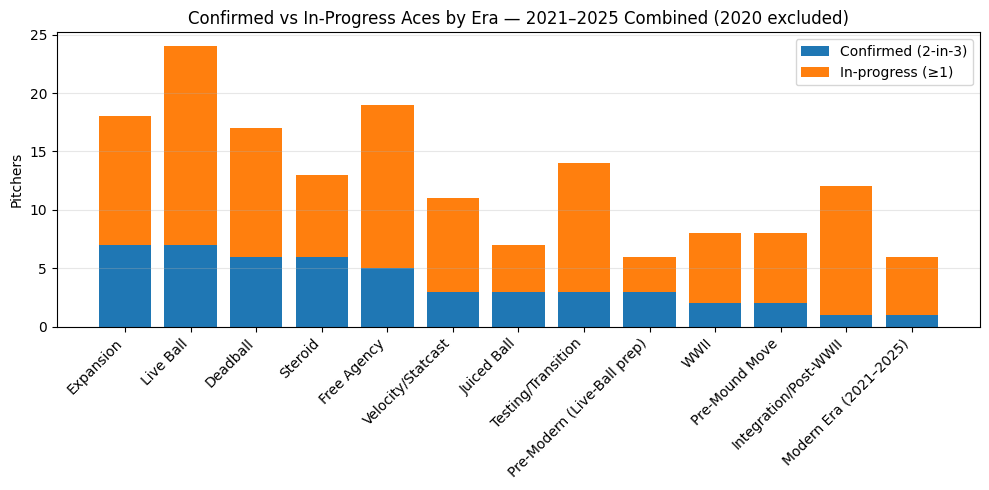

In [ ]:
# --- Confirmed vs In-Progress aces using the 2021–2025 "Modern Era" mapping ---

def confirmed_vs_inprogress_generic(df_with_era, era_col="Era_2125"):
    rows = []
    for era, g_era in df_with_era.groupby(era_col):
        confirmed, in_progress = set(), set()
        for name, g in g_era.groupby("Name"):
            years = sorted(g.loc[g["AceSeason"], "Season"].dropna().astype(int).unique())
            if not years:
                continue
            is_confirmed = any(sum(y0 <= y <= y0 + 2 for y in years) >= 2 for y0 in years)
            (confirmed if is_confirmed else in_progress).add(name)
        rows.append({
            era_col: era,
            "confirmed_aces_2in3": len(confirmed),
            "in_progress_aces_ge1": len(in_progress),
            "total_with_any_ace": len(confirmed) + len(in_progress),
        })
    return pd.DataFrame(rows).sort_values("confirmed_aces_2in3", ascending=False)

# compute table for the Modern Era mapping (assumes seasons_era_2125 already built)
confirmed_table_2125 = confirmed_vs_inprogress_generic(seasons_era_2125, era_col="Era_2125")
print("\n[2125] Confirmed vs In-progress aces per era:")
print(confirmed_table_2125.to_string(index=False))

# (Optional) show just the Modern Era (2021–2025) row
modern_row = confirmed_table_2125[confirmed_table_2125["Era_2125"] == "Modern Era (2021–2025)"]
if not modern_row.empty:
    print("\nModern Era (2021–2025) summary:")
    print(modern_row.to_string(index=False))


plt.figure(figsize=(10,5))
x = np.arange(len(confirmed_table_2125))
plt.bar(x, confirmed_table_2125["confirmed_aces_2in3"], label="Confirmed (2-in-3)")
plt.bar(x, confirmed_table_2125["in_progress_aces_ge1"],
        bottom=confirmed_table_2125["confirmed_aces_2in3"], label="In-progress (≥1)")
plt.xticks(x, confirmed_table_2125["Era_2125"], rotation=45, ha="right")
plt.ylabel("Pitchers")
plt.title("Confirmed vs In-Progress Aces by Era — 2021–2025 Combined (2020 excluded)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


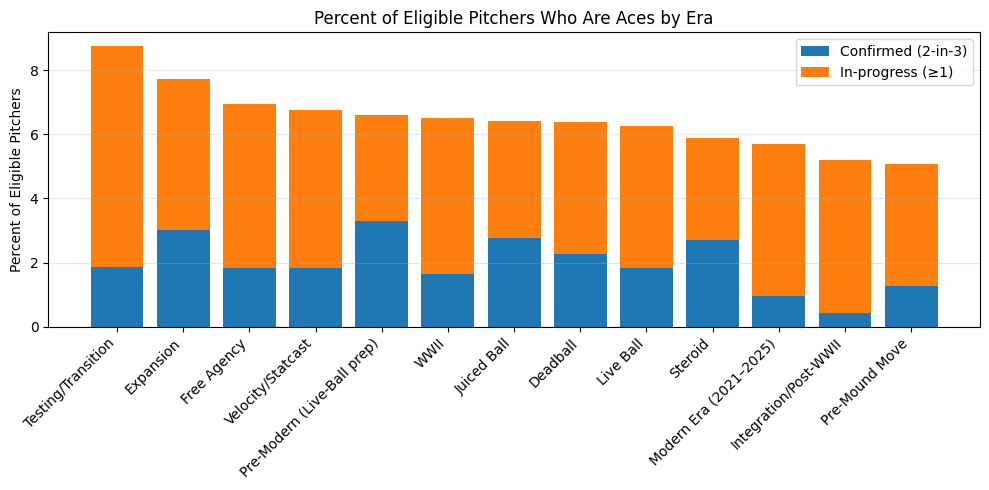

In [ ]:
# Ensure inputs exist
try:
    seasons_era_2125
except NameError:
    df_in = pd.read_csv(DATA_PATH)
    seasons = compute_ace_flags(df_in, war_min=WAR_MIN, cas_threshold=CAS_THRESHOLD, winsor=WINSOR)
    seasons_era_2125 = seasons[seasons["Season"] != 2020].copy()
    seasons_era_2125["Era_2125"] = seasons_era_2125["Season"].astype(int).apply(map_era_2125)

try:
    confirmed_table_2125
except NameError:
    def confirmed_vs_inprogress_generic(df_with_era, era_col="Era_2125"):
        rows = []
        for era, g_era in df_with_era.groupby(era_col):
            confirmed, in_progress = set(), set()
            for name, g in g_era.groupby("Name"):
                years = sorted(g.loc[g["AceSeason"], "Season"].dropna().astype(int).unique())
                if not years:
                    continue
                is_confirmed = any(sum(y0 <= y <= y0 + 2 for y in years) >= 2 for y0 in years)
                (confirmed if is_confirmed else in_progress).add(name)
            rows.append({era_col: era,
                         "confirmed_aces_2in3": len(confirmed),
                         "in_progress_aces_ge1": len(in_progress),
                         "total_with_any_ace": len(confirmed)+len(in_progress)})
        return pd.DataFrame(rows)
    confirmed_table_2125 = confirmed_vs_inprogress_generic(seasons_era_2125, era_col="Era_2125")

# Denominator: unique eligible pitchers per era (seasons_era_2125 already filtered to eligible)
denom = seasons_era_2125.groupby("Era_2125")["Name"].nunique().rename("unique_eligible_pitchers").reset_index()

# Percentages
df_pct = confirmed_table_2125.merge(denom, on="Era_2125", how="left")
df_pct["unique_eligible_pitchers"] = df_pct["unique_eligible_pitchers"].replace({0: np.nan})
df_pct["confirmed_pct"]    = 100 * df_pct["confirmed_aces_2in3"]  / df_pct["unique_eligible_pitchers"]
df_pct["in_progress_pct"]  = 100 * df_pct["in_progress_aces_ge1"] / df_pct["unique_eligible_pitchers"]
df_pct["any_ace_pct"]      = df_pct["confirmed_pct"] + df_pct["in_progress_pct"]
df_pct = df_pct.sort_values("any_ace_pct", ascending=False)

# Stacked percentage bar chart (one plot, matplotlib, no explicit colors)
plt.figure(figsize=(10,5))
x = np.arange(len(df_pct))
plt.bar(x, df_pct["confirmed_pct"], label="Confirmed (2-in-3)")
plt.bar(x, df_pct["in_progress_pct"], bottom=df_pct["confirmed_pct"], label="In-progress (≥1)")
plt.xticks(x, df_pct["Era_2125"], rotation=45, ha="right")
plt.ylabel("Percent of Eligible Pitchers")
plt.title("Percent of Eligible Pitchers Who Are Aces by Era")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Create table
era_table = (
    pd.DataFrame(ERA_BUCKETS_2125, columns=["Era", "Start_Year", "End_Year"])
      .assign(
          Range=lambda d: d["Start_Year"].astype(str) + "–" + d["End_Year"].astype(str),
          Years_in_Era=lambda d: d["End_Year"] - d["Start_Year"] + 1
      )
      .sort_values("Start_Year")
      .loc[:, ["Era", "Range", "Years_in_Era", "Start_Year", "End_Year"]]
      .reset_index(drop=True)
)

# Add an index column for readability
era_table.index = era_table.index + 1
era_table = era_table.rename_axis("No.").reset_index()

# Display as a pretty text table
print("\nEra definitions (for article):")
print(era_table.to_string(index=False))

# Also print a Markdown table (handy to paste into your draft)
try:
    md = era_table.to_markdown(index=False)
except Exception:
    # pandas.to_markdown may require 'tabulate'; if missing, fall back to CSV preview
    md = "Install 'tabulate' to use DataFrame.to_markdown()\n\n" + era_table.to_csv(index=False)
print("\nMarkdown version:\n")
print(md)

# Save to disk for reference
era_table.to_csv("/content/era_table_2125.csv", index=False)


Era definitions (for article):
 No.                         Era     Range  Years_in_Era  Start_Year  End_Year
   1              Pre-Mound Move 1871–1892            22        1871      1892
   2 Pre-Modern (Live-Ball prep) 1893–1900             8        1893      1900
   3                    Deadball 1901–1919            19        1901      1919
   4                   Live Ball 1920–1941            22        1920      1941
   5                        WWII 1942–1946             5        1942      1946
   6       Integration/Post-WWII 1947–1962            16        1947      1962
   7                   Expansion 1963–1976            14        1963      1976
   8                 Free Agency 1977–1992            16        1977      1992
   9                     Steroid 1993–2003            11        1993      2003
  10          Testing/Transition 2004–2009             6        2004      2009
  11           Velocity/Statcast 2010–2015             6        2010      2015
  12                

In [ ]:
# 1) Build the era DataFrame
era_table = (
    pd.DataFrame(ERA_BUCKETS_2125, columns=["Era", "Start_Year", "End_Year"])
      .assign(
          Range=lambda d: d["Start_Year"].astype(str) + "–" + d["End_Year"].astype(str),
          Years=lambda d: d["End_Year"] - d["Start_Year"] + 1
      )
      .sort_values("Start_Year")
      .loc[:, ["Era", "Range", "Years", "Start_Year", "End_Year"]]
      .reset_index(drop=True)
)
era_table.index = era_table.index + 1
era_table.insert(0, "No.", era_table.index)

# 2) Render a clean Unicode box table (great for copy-paste)
def box_table(df: pd.DataFrame) -> str:
    cols = list(df.columns)
    # compute column widths
    widths = {c: max(len(c), *(len(str(v)) for v in df[c])) for c in cols}

    # helpers
    def hline(left, mid, right, fill="─"):
        parts = [left]
        for i, c in enumerate(cols):
            parts.append(fill * (widths[c] + 2))
            parts.append(right if i == len(cols)-1 else mid)
        return "".join(parts)

    def row(vals, sep="│"):
        parts = [sep]
        for c, v in zip(cols, vals):
            s = str(v)
            parts.append(" " + s.ljust(widths[c]) + " ")
            parts.append(sep)
        return "".join(parts)

    top    = hline("┌", "┬", "┐")
    mid    = hline("├", "┼", "┤")
    bottom = hline("└", "┴", "┘")

    lines = [top, row(cols)]
    lines.append(mid)
    for _, r in df.iterrows():
        lines.append(row([r[c] for c in cols]))
    lines.append(bottom)
    return "\n".join(lines)

print("\nCopy-ready (Unicode box) era table:\n")
print(box_table(era_table))

# 3) Also print a Markdown version (easy to drop in your article)
try:
    md = era_table.to_markdown(index=False)
except Exception:
    # Fallback if tabulate isn't installed
    md = era_table.to_csv(index=False)
print("\nMarkdown version:\n")
print(md)



Copy-ready (Unicode box) era table:

┌─────┬─────────────────────────────┬───────────┬───────┬────────────┬──────────┐
│ No. │ Era                         │ Range     │ Years │ Start_Year │ End_Year │
├─────┼─────────────────────────────┼───────────┼───────┼────────────┼──────────┤
│ 1   │ Pre-Mound Move              │ 1871–1892 │ 22    │ 1871       │ 1892     │
│ 2   │ Pre-Modern (Live-Ball prep) │ 1893–1900 │ 8     │ 1893       │ 1900     │
│ 3   │ Deadball                    │ 1901–1919 │ 19    │ 1901       │ 1919     │
│ 4   │ Live Ball                   │ 1920–1941 │ 22    │ 1920       │ 1941     │
│ 5   │ WWII                        │ 1942–1946 │ 5     │ 1942       │ 1946     │
│ 6   │ Integration/Post-WWII       │ 1947–1962 │ 16    │ 1947       │ 1962     │
│ 7   │ Expansion                   │ 1963–1976 │ 14    │ 1963       │ 1976     │
│ 8   │ Free Agency                 │ 1977–1992 │ 16    │ 1977       │ 1992     │
│ 9   │ Steroid                     │ 1993–2003 │ 11    │ 19